<h2>PERMUTATION IMPORTANCE</h2>

<h3>How it Works</h3 <br>

Permutation importance uses models differently than anything you've seen so far, and many people find it confusing at first. So we'll start with an example to make it more concrete.
<img src="https://i.imgur.com/wjMAysV.png">

We want to predict a person's height when they become 20 years old, using data that is available at age 10.

Our data includes useful features (height at age 10), features with little predictive power (socks owned), as well as some other features we won't focus on in this explanation.

Permutation importance is calculated after a model has been fitted. So we won't change the model or change what predictions we'd get for a given value of height, sock-count, etc.

Instead we will ask the following question: If I randomly shuffle a single column of the validation data, leaving the target and all other columns in place, how would that affect the accuracy of predictions in that now-shuffled data?

<img src="https://i.imgur.com/h17tMUU.png">

Randomly re-ordering a single column should cause less accurate predictions, since the resulting data no longer corresponds to anything observed in the real world. Model accuracy especially suffers if we shuffle a column that the model relied on heavily for predictions. In this case, shuffling height at age 10 would cause terrible predictions. If we shuffled socks owned instead, the resulting predictions wouldn't suffer nearly as much.

With this insight, the process is as follows:

    1. Get a trained model.
    2. Shuffle the values in a single column, make predictions using the resulting dataset. Use these predictions and the true target values to calculate how much the loss function suffered from shuffling. That performance deterioration measures the importance of the variable you just shuffled.
    3. Return the data to the original order (undoing the shuffle from step 2). Now repeat step 2 with the next column in the dataset, until you have calculated the importance of each column.
  
<h3>INTERPRETING PERMUTATION IMPORTANCES</h3>  
    
The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "accuracy" as the performance metric).

Like most things in data science, there is some randomness to the exact performance change from a shuffling a column. We measure the amount of randomness in our permutation importance calculation by repeating the process with multiple shuffles. The number after the ± measures how performance varied from one-reshuffling to the next.

You'll occasionally see negative values for permutation importances. In those cases, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets.

In our dataset, from this analysis, the most important feature is LOS.

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import missingno as msno 

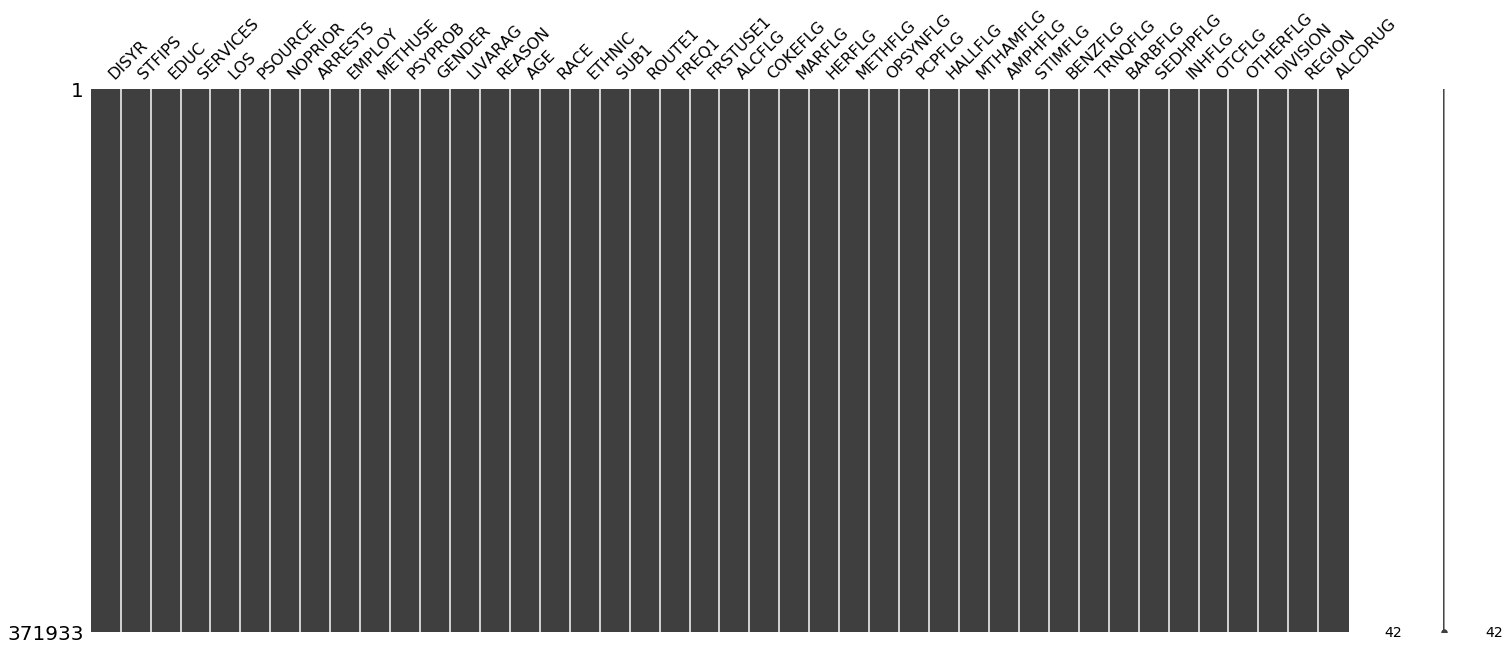

In [23]:
from funcs import *

data = pd.read_csv('../../../../stefan.nedelkovski/Treatment Episode Data Set: Discharges (TEDS-D)/tedsd_data_2017.csv')
data = filtering_data(data)
data = data.replace({-9:np.nan})

data = data.dropna()
msno.matrix(data)

In [24]:
y = data['REASON']
feature_names = [i for i in data.columns]
X = data[feature_names]
X = X.drop(columns=['REASON'])

,DISYR,STFIPS,EDUC,SERVICES,LOS,PSOURCE,NOPRIOR,ARRESTS,EMPLOY,METHUSE,...,BENZFLG,TRNQFLG,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,DIVISION,REGION,ALCDRUG
3,2017.0,2.0,5.0,7.0,33.0,7.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,4.0,1.0
5,2017.0,2.0,3.0,7.0,36.0,7.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,4.0,3.0
7,2017.0,2.0,2.0,7.0,33.0,1.0,0.0,1.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9.0,4.0,3.0
8,2017.0,2.0,2.0,7.0,33.0,1.0,0.0,0.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,4.0,1.0
12,2017.0,2.0,3.0,6.0,37.0,6.0,0.0,0.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1661045,2017.0,56.0,3.0,7.0,33.0,1.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,3.0
1661053,2017.0,56.0,5.0,5.0,33.0,1.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,1.0
1661116,2017.0,56.0,3.0,6.0,4.0,1.0,0.0,0.0,3.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,2.0
1661194,2017.0,56.0,4.0,7.0,34.0,6.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,1.0


In [25]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(n_estimators=100,
                                  random_state=0).fit(train_X, train_y)


In [ ]:
!pip install eli5

In [26]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist(), top_targets=41)

Weight,Feature
0.1204 ± 0.0019,LOS
0.0877 ± 0.0008,STFIPS
0.0824 ± 0.0012,SERVICES
0.0373 ± 0.0008,DIVISION
0.0188 ± 0.0009,REGION
0.0167 ± 0.0021,PSOURCE
0.0110 ± 0.0011,PSYPROB
0.0086 ± 0.0009,FREQ1
0.0060 ± 0.0006,METHUSE
0.0052 ± 0.0013,EMPLOY
